In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder, DatasetFolder
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

## Download dataset

In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/jutrera/stanford-car-dataset-by-classes-folder'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jiamingooi
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/jutrera/stanford-car-dataset-by-classes-folder


100%|██████████| 1.83G/1.83G [00:26<00:00, 73.0MB/s]


In [ ]:
DATA_DIR_TRAIN = '/content/stanford-car-dataset-by-classes-folder/car_data/car_data/train'
train_classes = os.listdir(DATA_DIR_TRAIN)

DATA_DIR_TEST = '/content/stanford-car-dataset-by-classes-folder/car_data/car_data/test'
test_classes = os.listdir(DATA_DIR_TEST)

train_classes[:5], test_classes[:5]

print(len(train_classes))
print(len(test_classes))

196
196


In [ ]:
def find_classes(dir):
    train_classes = os.listdir(dir)
    train_classes.sort()
    train_class_to_idx = {train_classes[i]: i for i in range(len(train_classes))}
    return train_classes, train_class_to_idx
    test_class_to_idx = {test_classes[i]: i for i in range(len(test_classes))}
    return test_classes, test_class_to_idx

train_classes, train_c_to_idx = find_classes(DATA_DIR_TRAIN)
test_classes, test_c_to_idx = find_classes(DATA_DIR_TEST)

In [ ]:
names = ['Acura RL Sedan 2012', 'Audi A5 Coupe 2012', 'BMW 3 Series Sedan 2012', 'Cadillac SRX SUV 2012', 'Ford Ranger SuperCab 2011', 'Honda Accord Coupe 2012', 'Hyundai Tucson SUV 2012', 'MINI Cooper Roadster Convertible 2012', 'Toyota Camry Sedan 2012', 'Volvo C30 Hatchback 2012']

In [ ]:
train_tfms = tt.Compose([tt.Resize((256, 256)),
                         tt.RandomRotation(0),
                         tt.ToTensor(),
                         tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tfms = tt.Compose([tt.Resize((256, 256)),
                        tt.ToTensor(),
                        tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
full_train_dataset = ImageFolder(DATA_DIR_TRAIN, transform = train_tfms)
full_test_dataset = ImageFolder(DATA_DIR_TEST, transform = test_tfms)

In [ ]:
names_set = set(names)
train_filtered_indices = [i for i, (path, _) in enumerate(full_train_dataset.samples) if os.path.basename(os.path.dirname(path)) in names_set]
test_filtered_indices = [i for i, (path, _) in enumerate(full_test_dataset.samples) if os.path.basename(os.path.dirname(path)) in names_set]

In [ ]:
original_classes = sorted(set(os.path.basename(os.path.dirname(full_train_dataset.samples[i][0])) for i in train_filtered_indices))
class_to_idx = {cls: idx for idx, cls in enumerate(original_classes)}
new_class_to_idx = {cls: idx for idx, cls in enumerate(names)}

In [ ]:
def remap_labels(dataset, indices, class_to_idx, new_class_to_idx):
    remapped_samples = []
    for i in indices:
        path, label = dataset.samples[i]
        class_name = dataset.classes[label]
        if class_name in new_class_to_idx:
            new_label = new_class_to_idx[class_name]
            remapped_samples.append((path, new_label))
    return remapped_samples

In [ ]:
train_remapped_samples = remap_labels(full_train_dataset, train_filtered_indices, class_to_idx, new_class_to_idx)
test_remapped_samples = remap_labels(full_test_dataset, test_filtered_indices, class_to_idx, new_class_to_idx)


In [ ]:
class RemappedDataset(torch.utils.data.Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
train_dataset = RemappedDataset(train_remapped_samples, transform=train_tfms)
test_dataset = RemappedDataset(test_remapped_samples, transform=test_tfms)


In [ ]:
len(train_dataset), len(test_dataset)

(405, 400)

## Training and Validation Datasets

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);

In [ ]:
val_percent = 0.1
val_size = int(val_percent * len(test_dataset))
train_size = len(test_dataset) - val_size

train_ds, val_ds = random_split(test_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(360, 40)

In [ ]:
batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 2, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size * 2, num_workers = 2, pin_memory=True)

In [ ]:
test_dl = DataLoader(train_dataset, batch_size, shuffle = True, num_workers = 2, pin_memory = True)

##Prepare model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from PIL import Image
import json
from matplotlib.ticker import FormatStrFormatter
import os

In [ ]:
model = models.resnet34(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 125MB/s]


In [ ]:
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_ftrs, len(names))
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

## Train Model

In [ ]:
# Implement a function for the validation pass
def validation(model, validloader, criterion):
    valid_loss = 0
    accuracy = 0

    # change model to work with cuda
    model.to('cuda')

    # Iterate over data from validloader
    for ii, (images, labels) in enumerate(validloader):

        # Change images and labels to work with cuda
        images, labels = images.to('cuda'), labels.to('cuda')

        # Forward pass image though model for prediction
        output = model.forward(images)
        # Calculate loss
        valid_loss += criterion(output, labels).item()
        # Calculate probability
        ps = torch.softmax(output, dim=1)

        # Calculate accuracy
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()

    return valid_loss / len(validloader), accuracy / len(validloader)

In [ ]:
epochs = 50
steps = 0
print_every = 10

# change to gpu mode
model.to('cuda')
model.train()

for e in range(epochs):
    running_loss = 0

    # Iterating over data to carry out training step
    for ii, (inputs, labels) in enumerate(train_dl):
        steps += 1

        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        # zeroing parameter gradients
        optimizer.zero_grad()

        # Forward and backward passes
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Carrying out validation step
        if steps % print_every == 0:
            # setting model to evaluation mode during validation
            model.eval()

            # Gradients are turned off as no longer in training
            with torch.no_grad():
                valid_loss, accuracy = validation(model, val_dl, criterion)

            print(f"No. epochs: {e+1}, \
            Training Loss: {round(running_loss/print_every,3)} \
            Valid Loss: {round(valid_loss/len(val_dl),3)} \
            Valid Accuracy: {round(float(accuracy/len(val_dl)),3)}")

            running_loss = 0
            # Turning training back on
            model.train()
            lrscheduler.step(accuracy * 100)


No. epochs: 4,             Training Loss: 0.22             Valid Loss: 2.27             Valid Accuracy: 0.15
No. epochs: 7,             Training Loss: 0.361             Valid Loss: 1.96             Valid Accuracy: 0.375
No. epochs: 10,             Training Loss: 0.379             Valid Loss: 1.614             Valid Accuracy: 0.6
No. epochs: 14,             Training Loss: 0.08             Valid Loss: 1.354             Valid Accuracy: 0.7
No. epochs: 17,             Training Loss: 0.122             Valid Loss: 1.169             Valid Accuracy: 0.7
No. epochs: 20,             Training Loss: 0.134             Valid Loss: 1.02             Valid Accuracy: 0.8
No. epochs: 24,             Training Loss: 0.029             Valid Loss: 0.909             Valid Accuracy: 0.8
No. epochs: 27,             Training Loss: 0.044             Valid Loss: 0.83             Valid Accuracy: 0.85
No. epochs: 30,             Training Loss: 0.052             Valid Loss: 0.77             Valid Accuracy: 0.825
No. 

In [ ]:
correct = 0
total = 0
model.to('cuda')


with torch.no_grad():
    for data in test_dl:
        images, labels = data
        images, labels = images.to('cuda'), labels.to('cuda')
        # Get probabilities
        outputs = model(images)
        # Turn probabilities into predictions
        _, predicted_outcome = torch.max(outputs.data, 1)
        # Total number of images
        total += labels.size(0)
        # Count number of cases in which predictions are correct
        correct += (predicted_outcome == labels).sum().item()

print(f"Test accuracy of model: {round(100 * correct / total,3)}%")

Test accuracy of model: 73.086%


## Save model

In [ ]:
# Saving: feature weights, new model.fc, index-to-class mapping, optimiser state, and No. of epochs
torch.save(model, '/content/classifier_10.pth')

## Load model

In [ ]:
# Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):

    model = torch.load(filepath, map_location=torch.device('cuda'))

    return model

## Predict image

In [ ]:
def process_image(image):

    # Process a PIL image for use in a PyTorch model

    # Converting image to PIL image using image file path
    pil_im = Image.open(image)

    # Building image transform
    transform = transforms.Compose([transforms.Resize((244,244)),
                                    #transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])

    # Transforming image for use with network
    pil_tfd = transform(pil_im)

    # Converting to Numpy array
    array_im_tfd = np.array(pil_tfd)

    return array_im_tfd

In [ ]:
def predict(image_path, model, topk=5):
    # Implement the code to predict the class from an image file

    # Loading model - using .cpu() for working with CPUs
    loaded_model = load_checkpoint(model).cpu()
    # Pre-processing image
    img = process_image(image_path)
    # Converting to torch tensor from Numpy array
    img_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Adding dimension to image to comply with (B x C x W x H) input of model
    img_add_dim = img_tensor.unsqueeze_(0)

    # Setting model to evaluation mode and turning off gradients
    loaded_model.eval()
    with torch.no_grad():
        # Running image through network
        output = loaded_model.forward(img_add_dim)

    #conf, predicted = torch.max(output.data, 1)
    probs_top = output.topk(topk)[0]
    predicted_top = output.topk(topk)[1]

    # Converting probabilities and outputs to lists
    conf = np.array(probs_top)[0]
    predicted = np.array(predicted_top)[0]

    #return probs_top_list, index_top_list
    return conf, predicted

In [ ]:
# tie the class indices to their names
data_dir = '/content/stanford-car-dataset-by-classes-folder/car_data/car_data/'
def find_classes(dir, names):
    # Only include classes that are in the names list
    classes = [cls for cls in os.listdir(dir) if cls in names]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx
classes, c_to_idx = find_classes(data_dir+"train", names)

print(classes, c_to_idx)

['Acura RL Sedan 2012', 'Audi A5 Coupe 2012', 'BMW 3 Series Sedan 2012', 'Cadillac SRX SUV 2012', 'Ford Ranger SuperCab 2011', 'Honda Accord Coupe 2012', 'Hyundai Tucson SUV 2012', 'MINI Cooper Roadster Convertible 2012', 'Toyota Camry Sedan 2012', 'Volvo C30 Hatchback 2012'] {'Acura RL Sedan 2012': 0, 'Audi A5 Coupe 2012': 1, 'BMW 3 Series Sedan 2012': 2, 'Cadillac SRX SUV 2012': 3, 'Ford Ranger SuperCab 2011': 4, 'Honda Accord Coupe 2012': 5, 'Hyundai Tucson SUV 2012': 6, 'MINI Cooper Roadster Convertible 2012': 7, 'Toyota Camry Sedan 2012': 8, 'Volvo C30 Hatchback 2012': 9}


In [ ]:
def plot_solution(cardir, model):
  # Testing predict function

  # Inputs are paths to saved model and test image
  model_path = '/content/classifier_10.pth'
  image_path = cardir
  carname = cardir.split('/')[1]

  conf2, predicted1 = predict(image_path, model_path, topk=5)
  # Converting classes to names
  names = []
  for i in range(5):

      names += [classes[predicted1[i]]]


  # Creating PIL image
  image = Image.open(image_path)

  # Plotting test image and predicted probabilites
  f, ax = plt.subplots(2,figsize = (6,10))

  ax[0].imshow(image)
  ax[0].set_title(carname)

  y_names = np.arange(len(names))
  ax[1].barh(y_names, conf2/conf2.sum(), color='darkblue')
  ax[1].set_yticks(y_names)
  ax[1].set_yticklabels(names)
  ax[1].invert_yaxis()

  plt.show()

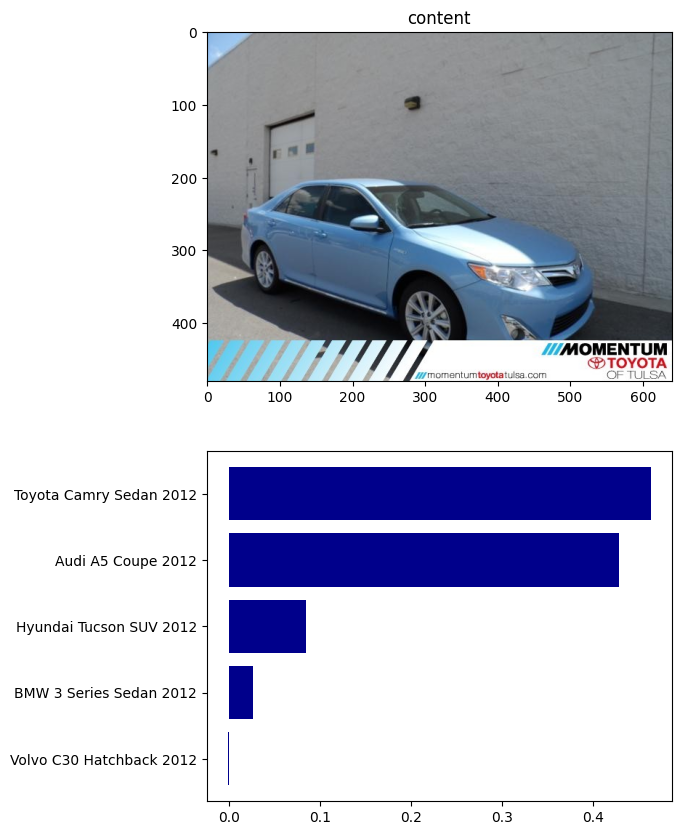

In [ ]:
cardir='/content/stanford-car-dataset-by-classes-folder/car_data/car_data/train/Toyota Camry Sedan 2012/00431.jpg'
plot_solution(cardir, model)